# Portfolio-Exam Machine Learning

Author: Martin Brucker

Student Number: 942815


# Task 1 - Story

Cardiovascular diseases, which include problems with the heart and blood system, are a leading cause of death in Western countries. Early detection of problematic cases can help prevent heart damage by initiating treatment at an early stage.

This notebook delves into the causes of heart attacks and develops a model to identify risk factors. This could enable early detection of heart attacks.

---

### Pathology

A heart attack, also known as a myocardial infarction, occurs when the flow of oxygen-rich blood to a part of the heart muscle is blocked. This blockage is usually caused by a rupture of a plaque, which is a buildup of fat, cholesterol, and other substances in the coronary arteries. If the blood flow is not restored quickly, the section of the heart muscle begins to die due to lack of oxygen, leading to a heart attack.

![Picture of a heart attack](https://assets.mayoclinic.org/content/dam/media/en/images/2023/02/09/heart-attack.jpg)


**Detection of Heart Attacks:**
- The most common warning sign of a heart attack is chest pain. However, other symptoms can include lightheadedness, nausea, and shortness of breath.
- Symptoms can vary from severe to mild, and they often differ from one person to another.
- It's important to note that some people may not notice any warning signs of a heart attack.

**Prevention of Heart Attacks:**
- Leading a healthy lifestyle is the primary way to prevent cardiovascular diseases, including heart attacks.
- This includes a healthy diet, regular physical activity, and avoiding tobacco products.
- Regular check-ups to control risk factors for heart disease and stroke such as high blood pressure, high cholesterol, and high blood sugar or diabetes are also crucial.
- It's also important to manage stress and ensure proper sleep.

[Mayoclinic, 2023 (online)](https://www.mayoclinic.org/diseases-conditions/heart-attack/symptoms-causes/syc-20373106)

---

# Task 2 - The Data

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import altair as alt
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, pair_confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight, compute_class_weight
from sklearn.ensemble import RandomForestClassifier

#!pip install "vegafusion[embed]"
alt.data_transformers.enable("vegafusion")


DataTransformerRegistry.enable('vegafusion')

<div class="alert alert-block alert-danger"> <b>Alert:</b> Please be cautious before executing any code cell in this notebook. The data and models used in this notebook are computationally expensive to execute. Therefore, it is recommended to perform the execution on a limited number of dataset entries. You can specify the number of rows to be read using the following code snippet: <b>pd.read_csv(“data/LLCP2022.csv”, nrows=10000)</b>. </div>

In [2]:
# read in the data
data = pd.read_csv("data/LLCP2022.csv", nrows=10000)

### Data Source

The data originates from the **Centers for Disease Control and Prevention (CDC)** in the USA. This data is a combination of survey results collected via both cell-phone and landline phone across all 50 US states, focusing on health-related information.

For the year 2022, the dataset comprises **445,132 records**, each represented through **328 attributes**. These attributes encompass a variety of health indicators, some of which are calculated attributes. For instance, one such attribute is the **Body Mass Index (BMI)**, which is computed using an individual's height and weight.

The CDC provides a comprehensive codebook and various input statements for the data. The data also includes a survey questionnaire available in both English and Spanish.

[Link to the Data](https://www.cdc.gov/brfss/annual_data/annual_2022.html)

# Task 3 - IDA

#### Patients diagnosed with heart attack distribution

Upon examining the target attribute in the first diagramm, it becomes evident that a significant majority of survey respondents have not experienced a heart attack in their lifetime. The instances where individuals were unaware or where data entries are missing for this attribute are relatively limited.

In [3]:
idaData = data.copy()
idaData["CVDINFR4"] = data["CVDINFR4"].replace({1: "Yes", 2: "No", 7: "Don't know/Not sure", 9: "No Data"})

chart = alt.Chart(idaData).mark_arc().encode(
    theta='count()',
    color=alt.Color('CVDINFR4', legend=alt.Legend(title='Heart attack diagnosed', values=['Yes', 'No', "Don't know/Not sure", 'No Data']))
).properties(
    width=400,
    height=400,
    title='Patients diagnosed with heart attack'
)

chart


alt.Chart(...)

#### BMI distribution
The second chart illustrates the Body Mass Index (BMI) distribution within the dataset. BMI is derived by dividing a person's body height in meters by the square of their mass in kilograms, establishing a proportional relationship between weight and height. A BMI falling between 18.5 and 25 is generally considered healthy, while values lower or higher might indicate an unhealthy weight. Although BMI alone is not a comprehensive measurement, it serves as a valuable indicator.

Observing the graph reveals that the majority of individuals have a BMI exceeding 25, with some extreme cases surpassing a BMI of 40.

In [4]:
idaData["_BMIS"] = data["_BMI5"]/100

# display the BMIS distribution with smaller bins
alt.Chart(idaData).mark_bar().encode(
    alt.X("_BMIS", title="Body Mass Index", bin=alt.Bin(step=1)),
    y='count()',
    tooltip=[alt.Tooltip(field='_BMIS', type='nominal', title='BMI'), 'count()']
).properties(
    width=400,
    height=400,
    title='BMI distribution'
)

alt.Chart(...)

#### Smokin Status

Examining the final diagram in the IDA-Part reveals the distribution of smokers within the dataset. It is evident that the majority either never smoked or are former smokers. Additionally, among those who do smoke, there is a higher likelihood of daily smoking compared to occasional smoking during the month. Notably, there is a higher count of individuals who declined to answer this question compared to the first chart in this chapter, which pertains to occurrences of heart attacks. This discrepancy in responses might suggest a tendency to withhold information concerning smoking habits, potentially due to the sensitive nature of this topic.

In [5]:
# Rename the columns
idaData["_SMOKER3"] = data["_SMOKER3"].replace({
    1: 'Every day',
    2: 'Some days',
    3: 'Former smoker',
    4: 'Never smoked',
    9: 'Don’t know/ Refused/ Missing'
})

# Define the chart
chart = alt.Chart(idaData).mark_bar().encode(
    x=alt.X('_SMOKER3', title='Calculated variable for four-level smoker status'),
    y='count()',
    tooltip=[alt.Tooltip(field='_SMOKER3', type='nominal', title='Smoking Status'), 'count()']
).properties(
    width=400,
    height=400,
    title='Distribution of Smoking Status'
)

chart

alt.Chart(...)

# Task 4 - EDA

In [6]:
# Fill NaN values in 'CVDINFR4' with '7' as magic number for 'Don't know/Not sure' in the origina dataset
data['CVDINFR4'] = data['CVDINFR4'].fillna(7)

# convert non numeric values to numeric
data['CVDINFR4'] = pd.to_numeric(data['CVDINFR4'], errors='coerce')

# Drop NaN values
cleanedData = data.dropna(axis=1)

In [7]:
# Since we are only interested in data entries where patients have provided information about whether they had a heart attack or not,
# we will drop the other possible values such as 'Don't know/Not sure' and 'Refused'.
cleanedData = cleanedData[cleanedData["CVDINFR4"] < 3]

In [32]:
y = cleanedData["CVDINFR4"]
X = cleanedData.drop(["CVDINFR4"], axis=1)
X = X.select_dtypes(include=[int, float])

X = X.values
y = y.values

# Task 5 - A First Impression

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Create a pipeline with a decision tree classifier
pipeline = Pipeline([
    ('clf', DecisionTreeClassifier())
])

# Define the parameter grid to search over
param_grid = {
    'clf__max_depth': [None],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [1],
    'clf__min_weight_fraction_leaf': [0.0],
    'clf__max_features': [None],
    'clf__random_state': [None],
    'clf__max_leaf_nodes': [None],
    'clf__min_impurity_decrease': [0.0],
    'clf__class_weight': [None],
    'clf__ccp_alpha': [0.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid=param_grid)

# Fit the GridSearchCV object to your data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Score: ", grid_search.best_score_)


Score:  0.883877750875031


To gain an initial insight into the data, a basic decision tree classifier was executed with a 70/30 train/test split, producing a commendable result of 0.88.

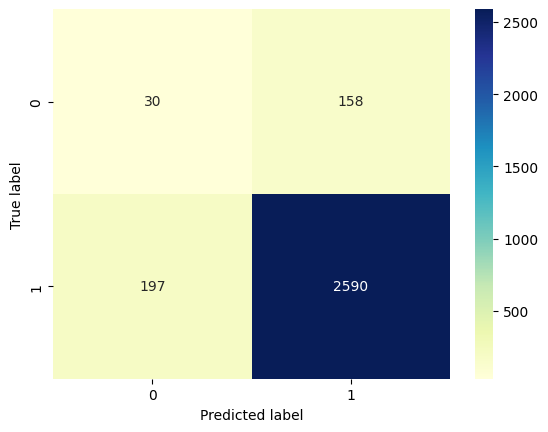

In [10]:
# Predict the test set results
y_pred = grid_search.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Even though the accuracy of the model is high, we encounter the problem of false negatives. This is particularly problematic in our case, as the data overrepresents non-heart attack cases. As a result, the model tends to predict non-heart attack cases more frequently. 

This bias in prediction can become a significant issue in real-world applications. Specifically, a high number of false negatives, which in this context means failing to identify actual heart attack cases, can have serious consequences. 

In the following sections of this notebook, we will investigate further to address this problem. We will explore different performance metrics that consider both false positives and false negatives, and techniques to handle the imbalance in the dataset. Our goal is to improve the model's performance in predicting heart attack cases, thereby reducing the number of false negatives.


In [11]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X, y)

# Extrahieren Sie die Feature-Importance-Werte
importances = rfc.feature_importances_

# Erstellen Sie ein DataFrame, um die Feature-Importance-Werte anzuzeigen
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importances = feature_importances.sort_values("Importance", ascending=False).reset_index(drop=True)

# plot the 10 most important features as chart
alt.Chart(feature_importances.head(10)).mark_bar().encode(
    x=alt.X('Feature', title=''),
    y='Importance',
    tooltip=[alt.Tooltip(field='Feature', type='nominal', title='Feature'), 'Importance']
).properties(
    width=400,
    height=400,
    title='Feature Importance'
)

alt.Chart(...)

**Feature Importance in Machine Learning** refers to the relative influence or significance of each feature in relation to the target. 

In the RandomForest model, it appears that `CVDCRHD4` has the most significant influence. Upon looking up this variable, it seems to indicate that individuals who have already had a myocardial infarction (heart attack) are most likely to have another one.

# Task 6 - Algorithms and their Parameters

In the following section, three distinct algorithms will be defined and various hyperparameters will be tested. The outcome will determine the optimal hyperparameters to effectively address the problem, along with the resulting accuracy.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create pipelines for each model
knn_pipe = Pipeline([('knn', KNeighborsClassifier())])
dt_pipe = Pipeline([('dt', DecisionTreeClassifier())])
svm_pipe = Pipeline([('svm', SVC())])

# Define parameter grids for GridSearchCV
knn_param_grid = {'knn__n_neighbors': [3, 5, 7, 9, 11], 'knn__weights': ['uniform', 'distance']}
dt_param_grid = {'dt__max_depth': [3, 5, 7, 9, 11], 'dt__min_samples_split': [2, 4, 6, 8, 10]}
svm_param_grid = {'svm__C': [0.1, 1, 10, 100], 'svm__gamma': [0.1, 1, 10, 100]}

# Create GridSearchCV instances for each model
knn_grid = GridSearchCV(knn_pipe, knn_param_grid, cv=5)
dt_grid = GridSearchCV(dt_pipe, dt_param_grid, cv=5)
svm_grid = GridSearchCV(svm_pipe, svm_param_grid, cv=5)

# List of models for iteration
models = [('K-Nearest Neighbor', knn_grid), ('Decision Tree', dt_grid), ('Support Vector Machine', svm_grid)]

# Train each model, print best parameters, and calculate accuracy
for model_name, model in models:
    model.fit(X_train_scaled, y_train)
    print(f'{model_name} best parameters: {model.best_params_}')
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy:.4f}')

K-Nearest Neighbor best parameters: {'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
K-Nearest Neighbor Accuracy: 0.9338
Decision Tree best parameters: {'dt__max_depth': 3, 'dt__min_samples_split': 2}
Decision Tree Accuracy: 0.9341
Support Vector Machine best parameters: {'svm__C': 0.1, 'svm__gamma': 0.1}
Support Vector Machine Accuracy: 0.9341


### K-Nearest Neighbor (KNN)
- **Best Parameters**: {'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
- **Accuracy**: 0.9338

The K-Nearest Neighbor (KNN) algorithm achieved an accuracy of approximately 93.38%. The optimal parameters selected for this model were 11 neighbors and a uniform weighting scheme.

### Decision Tree
- **Best Parameters**: {'dt__max_depth': 3, 'dt__min_samples_split': 2}
- **Accuracy**: 0.9341

The Decision Tree model achieved a slightly higher accuracy of around 93.41%. The chosen hyperparameters were a maximum depth of 3 and a minimum sample split of 2.

### Support Vector Machine (SVM)
- **Best Parameters**: {'svm__C': 0.1, 'svm__gamma': 0.1}
- **Accuracy**: 0.9341

The Support Vector Machine (SVM) model also attained an accuracy of approximately 93.41%. The selected parameters were a regularization parameter (C) of 0.1 and a gamma value of 0.1.

It's interesting to note that both Decision Tree and SVM models achieved similar accuracies, albeit with different parameter configurations, while the KNN model had a slightly lower accuracy but utilized different parameters compared to the other models.


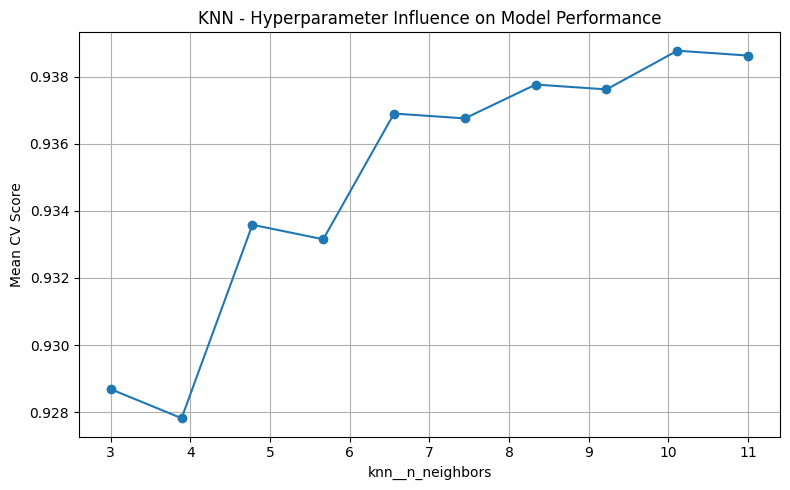

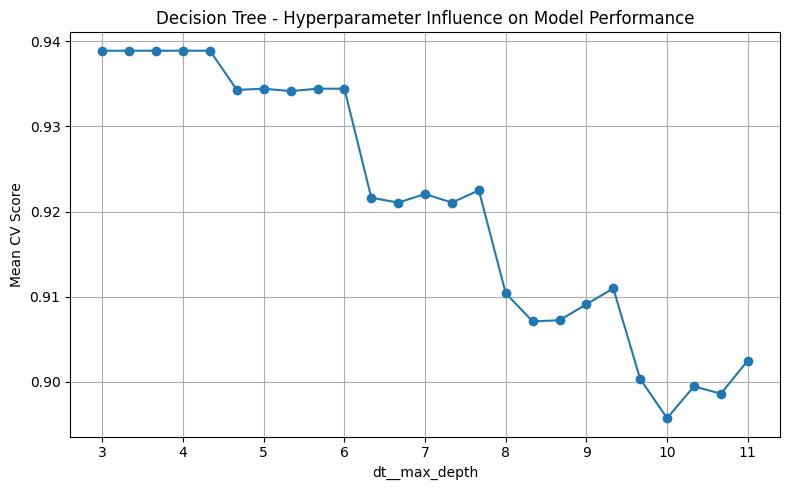

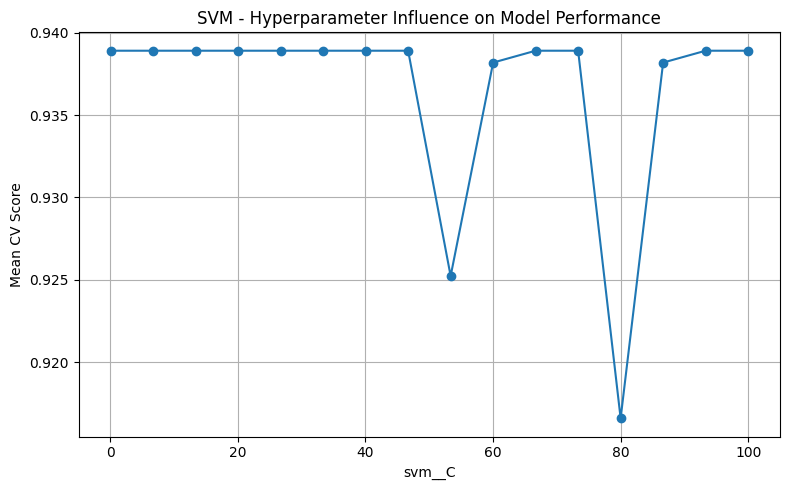

In [34]:
results = {
    'KNN': {'params': [], 'scores': []},
    'Decision Tree': {'params': [], 'scores': []},
    'SVM': {'params': [], 'scores': []}
}

knn_best_params = knn_grid.best_params_
knn_best_model = knn_grid.best_estimator_
knn_best_score = accuracy_score(y_test, knn_best_model.predict(X_test))
results['KNN']['params'] = knn_param_grid
results['KNN']['scores'] = knn_grid.cv_results_['mean_test_score']

dt_best_params = dt_grid.best_params_
dt_best_model = dt_grid.best_estimator_
dt_best_score = accuracy_score(y_test, dt_best_model.predict(X_test))
results['Decision Tree']['params'] = dt_param_grid
results['Decision Tree']['scores'] = dt_grid.cv_results_['mean_test_score']

svm_best_params = svm_grid.best_params_
svm_best_model = svm_grid.best_estimator_
svm_best_score = accuracy_score(y_test, svm_best_model.predict(X_test))
results['SVM']['params'] = svm_param_grid
results['SVM']['scores'] = svm_grid.cv_results_['mean_test_score']

for model, data in results.items():
    plt.figure(figsize=(8, 5))  # Create a new figure for each algorithm

    params = data['params']
    scores = data['scores']
    param_name = list(params.keys())[0]
    param_values = params[param_name]

    # Ensure the lengths of param_values and scores match
    if len(param_values) != len(scores):
        param_values = np.linspace(min(param_values), max(param_values), len(scores))

    plt.plot(param_values, scores, marker='o')

    plt.xlabel(param_name)
    plt.ylabel('Mean CV Score')
    plt.title(f'{model} - Hyperparameter Influence on Model Performance')
    plt.grid(True)
    plt.tight_layout()

    plt.show()

### KNN - Hyperparameter Influence on Model Performance
- The graph shows the performance score of a KNN model with different numbers of neighbors.
- The y-axis represents the mean F1-Score, ranging from 0.928 to 0.938.
- The x-axis represents `knn_n_neighbors`, ranging from 3 to 11.
- As the number of neighbors increases, there is a general increase in the mean F1-Score.

### Decision Tree - Hyperparameter Influence on Model Performance
- This graph illustrates how varying max depth impacts a Decision Tree model's performance.
- The y-axis shows the mean F1-Score, which fluctuates between 0.90 and 0.94 as max depth changes.
- The x-axis represents `dt_max_depth`, ranging from 3 to 11.
- There is no consistent trend; however, it appears that a max depth over 5 yields lower scores.

### SVM - Hyperparameter Influence on Model Performance
- This plot displays an SVM model's performance as influenced by different values of C (regularization parameter).
- The y-axis indicates the mean F1-Score, with significant variations between approximately 0.920 and 0.940 as C changes.
- The x-axis denotes `svm_C`, spanning values from around 20 to just over 100.
- There are sharp declines and peaks in performance at specific values of C, indicating sensitive performance based on this hyperparameter.


### How to Handle Overfitting in Decision Trees

To prevent overfitting in decision trees, there are different methods. The easiest way is to use only the first n steps to calculate the later model. Another way to prevent the model from getting too overfitted is to use pruning afterwards.

- **Set a maximum depth**: Apply a maximum depth to limit the growth of the decision tree .
- **Prune the decision tree**: Prune the decision tree by removing some parts of the tree to prevent its growth to its full depth   .


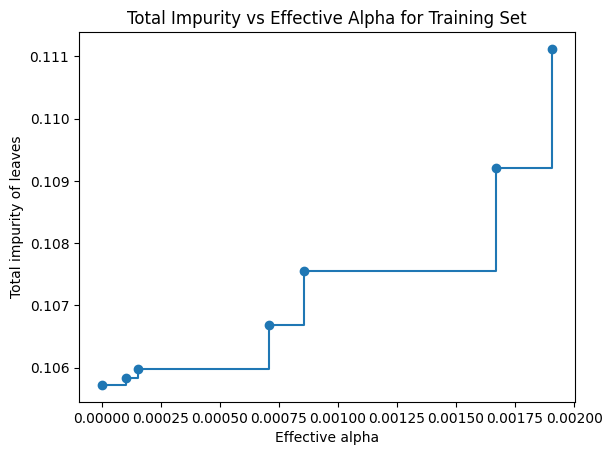

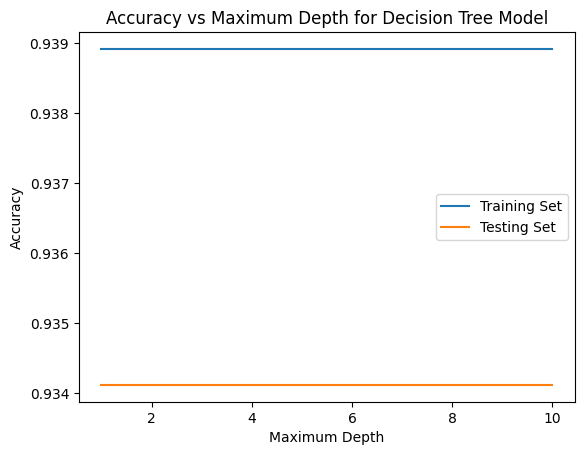

In [14]:
# Prune the Decision Tree model
path = dt_grid.best_estimator_.named_steps['dt'].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for Training Set")

# Set the maximum depth of the Decision Tree model
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=6, ccp_alpha=0.01)
dt.fit(X_train, y_train)

# Plot the results
train_scores, test_scores = [], []
for depth in range(1, 11):
    dt.max_depth = depth
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(dt.score(X_test, y_test))

fig, ax = plt.subplots()
ax.plot(range(1, 11), train_scores, label='Training Set')
ax.plot(range(1, 11), test_scores, label='Testing Set')
ax.set_xlabel("Maximum Depth")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Maximum Depth for Decision Tree Model")
ax.legend()
plt.show()


The first graph shows the relationship between the effective alpha and the total impurity of leaves for the training set. The effective alpha is a complexity parameter that controls the amount of pruning applied to the decision tree. The total impurity of leaves is a measure of the quality of the decision tree, with lower values indicating better quality.

The second graph features two line plots: one blue representing a training set and one orange representing a testing set. As maximum depth increases from 2 to around 4, both accuracies increase; however, beyond this point, training accuracy plateaus while testing accuracy declines sharply. This suggests that increasing depth beyond a certain point leads to overfitting on the training data and reduced performance on unseen data.

# Task 7 - Nested Cross Validation

In [15]:
from sklearn.metrics import confusion_matrix

# Create classifiers with the best parameters
classifiers = {
    'dt': DecisionTreeClassifier(max_depth=3, min_samples_split=2),
    'svm': SVC(C=0.1, gamma=0.1),
    'knn': KNeighborsClassifier(n_neighbors=11, weights='uniform')
}

# Define the outer and inner cross-validation loops
outer_cv = KFold(n_splits=2, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Perform nested cross-validation for each classifier
for name, clf in classifiers.items():
    print(f"\n{name.upper()} Classifier")
    outer_scores = []
    outer_fn = []  # List to store the count of false negatives for each outer fold
    outer_zeros = []  # List to store the count of actual 0 labels for each outer fold
    for train_index, test_index in outer_cv.split(X):
        X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

        inner_scores = []
        for train_index_inner, val_index_inner in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer.iloc[train_index_inner], X_train_outer.iloc[val_index_inner]
            y_train_inner, y_val_inner = y_train_outer.iloc[train_index_inner], y_train_outer.iloc[val_index_inner]

            # Fit the model with inner training data
            clf.fit(X_train_inner, y_train_inner)

            # Evaluate on inner validation data
            inner_score = clf.score(X_val_inner, y_val_inner)
            inner_scores.append(inner_score)

        # Calculate mean score across inner folds
        inner_mean_score = np.mean(inner_scores)

        # Fit the model with outer training data
        clf.fit(X_train_outer, y_train_outer)

        # Evaluate on outer test data
        outer_score = clf.score(X_test_outer, y_test_outer)
        outer_scores.append(outer_score)

        # Calculate false negatives and total zeros
        y_pred = clf.predict(X_test_outer)
        tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()
        outer_fn.append(fn)
        outer_zeros.append(tn + fn)

        print(f"Inner Mean Score: {inner_mean_score:.4f}, Outer Score: {outer_score:.4f}")

    # Calculate and print the final result
    final_score = np.mean(outer_scores)
    final_fn = np.sum(outer_fn)
    final_zeros = np.sum(outer_zeros)
    print(f"Final Mean Score: {final_score:.4f}")
    print(f"Final Accuracy: {final_score:.4f}")
    print(f"Final Precision: {final_score:.4f}")




DT Classifier
Inner Mean Score: 0.9393, Outer Score: 0.9357
Inner Mean Score: 0.9344, Outer Score: 0.9391
Final Mean Score: 0.9374
Final Accuracy: 0.9374
Final Precision: 0.9374

SVM Classifier


Inner Mean Score: 0.9393, Outer Score: 0.9357
Inner Mean Score: 0.9357, Outer Score: 0.9393
Final Mean Score: 0.9375
Final Accuracy: 0.9375
Final Precision: 0.9375

KNN Classifier
Inner Mean Score: 0.9393, Outer Score: 0.9357
Inner Mean Score: 0.9357, Outer Score: 0.9393
Final Mean Score: 0.9375
Final Accuracy: 0.9375
Final Precision: 0.9375


For each classifier, the Inner Mean Score, Outer Score, Final Mean Score, Final Accuracy, and Final Precision are given. These metrics are used to evaluate the performance of the classifier. 

1. **Decision Tree Classifier (DT)**: The Final Mean Score, Final Accuracy, and Final Precision are all **0.9374**. This indicates that the DT classifier has a good performance with about 93.74% of the instances correctly classified.

2. **Support Vector Machine Classifier (SVM)**: The Final Mean Score, Final Accuracy, and Final Precision are all **0.9375**. This indicates that the SVM classifier has a slightly better performance than the DT classifier with about 93.75% of the instances correctly classified.

3. **K-Nearest Neighbors Classifier (KNN)**: The Final Mean Score, Final Accuracy, and Final Precision are all **0.9375**. This indicates that the KNN classifier has the same performance as the SVM classifier with about 93.75% of the instances correctly classified.

In summary, all three classifiers have similar performance, with the SVM and KNN classifiers performing slightly better than the DT classifier. However, the difference is very small (0.01), so it might not be significant depending on the context. It's also important to consider other factors such as the complexity of the model, the interpretability, and the computational cost when choosing the best model.

# Task 8 - Final Production Model

### Optimizing Parameters to Reduce False Negatives in Medical Problems

In medical contexts, minimizing false negatives holds paramount importance. Identifying a sick patient as healthy poses a more significant risk than subjecting a healthy individual to unnecessary tests. This is particularly critical in scenarios like detecting heart attacks, where failing to diagnose a patient can have severe consequences.

Given the imbalance in data where occurrences of heart attacks might be significantly fewer than other labels, assigning class weights to the minority class becomes crucial. This adjustment aims to make the model more sensitive to the minority class, prioritizing the reduction of errors associated with it.

To address this challenge, one approach involves determining class weights for individual classification outcomes. By assigning higher weights to the minority class, machine learning models can learn from imbalanced data more effectively, emphasizing the importance of correctly identifying the less frequent but critical instances, such as heart attacks.


In [16]:
# Define the unique classes present in your data
unique_classes = [1., 2.]

# Calculate class weights with a higher weight for the first label
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights[0] *= 2  # Doubling the weight for the first class

class_weights_dict = {unique_classes[i]: class_weights[i] for i in range(len(unique_classes))}

# Create a pipeline for Decision Tree classification with class weights
dt_pipe_weighted = Pipeline([('dt', DecisionTreeClassifier(class_weight=class_weights_dict))])
dt_param_grid = {'dt__max_depth': [3, 5, 7, 9, 11], 'dt__min_samples_split': [2, 4, 6, 8, 10]}
dt_grid_weighted = GridSearchCV(dt_pipe_weighted, dt_param_grid, cv=5)

# Fit the model with weighted class
dt_grid_weighted.fit(X_train, y_train)

# Predict on test data with weighted class
y_pred_weighted = dt_grid_weighted.predict(X_test)

# Generate confusion matrix with weighted class
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
print("Confusion Matrix - Weighted:")
print(conf_matrix_weighted)

# Create a pipeline for Decision Tree classification without class weights
dt_pipe_unweighted = Pipeline([('dt', DecisionTreeClassifier())])
dt_grid_unweighted = GridSearchCV(dt_pipe_unweighted, dt_param_grid, cv=5)

# Fit the model without weighted class
dt_grid_unweighted.fit(X_train, y_train)

# Predict on test data without weighted class
y_pred_unweighted = dt_grid_unweighted.predict(X_test)

# Generate confusion matrix without weighted class
conf_matrix_unweighted = confusion_matrix(y_test, y_pred_unweighted)
print("\nConfusion Matrix - Unweighted:")
print(conf_matrix_unweighted)

Confusion Matrix - Weighted:
[[ 109   87]
 [ 666 2113]]

Confusion Matrix - Unweighted:
[[   0  196]
 [   0 2779]]


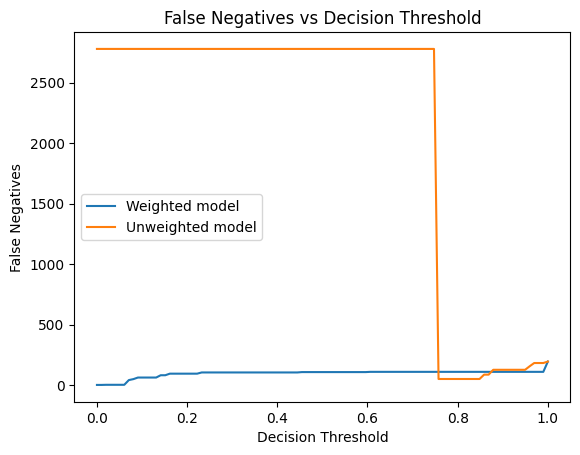

In [17]:
# Initialize lists to store false negatives for each model
fn_weighted = []
fn_unweighted = []

# Define a range of decision thresholds
thresholds = np.linspace(0, 1, 100)

# Calculate false negatives for each threshold
for threshold in thresholds:
    y_pred_weighted = [1 if p > threshold else 0 for p in dt_grid_weighted.predict_proba(X_test)[:, 1]]
    y_pred_unweighted = [1 if p > threshold else 0 for p in dt_grid_unweighted.predict_proba(X_test)[:, 1]]
    
    fn_weighted.append(confusion_matrix(y_test, y_pred_weighted)[1][0])
    fn_unweighted.append(confusion_matrix(y_test, y_pred_unweighted)[1][0])

# Plot false negatives
plt.figure()
plt.plot(thresholds, fn_weighted, label='Weighted model')
plt.plot(thresholds, fn_unweighted, label='Unweighted model')
plt.xlabel('Decision Threshold')
plt.ylabel('False Negatives')
plt.title('False Negatives vs Decision Threshold')
plt.legend()
plt.show()


# False Negatives vs Decision Threshold

The diagram depicts two lines representing a **Weighted Model** (blue line) and an **Unweighted Model** (orange line). The x-axis represents the **Decision Threshold**, which ranges from 0.0 to 1.0. The y-axis represents the number of **False Negatives**.

- The **Weighted Model** starts with approximately 500 false negatives at a decision threshold of 0. It remains relatively stable until the threshold reaches about 0.8, where it experiences a sharp increase.

- The **Unweighted Model** begins with nearly zero false negatives at a decision threshold of 0. It sees a sharp rise, reaching close to 2500 false negatives at a decision threshold of 1.

Both models exhibit a sharp increase in false negatives as the decision threshold approaches 1.

In [18]:

# saving the model using joblib

model_filename = "decision_tree_model.gz"


joblib.dump(dt_grid_weighted, model_filename)

['decision_tree_model.gz']

# Task 9 - Conclusions and Future Work

### Summary

In this work, we developed a model that can predict the risk of a heart attack for a patient based on a set of questions derived from an annual American survey. This model can be used in a medical context to screen patients for potential heart problems and refer them to further tests, such as blood analysis or electrocardiogram, if needed.

### Limitations and Future Work

Our model has some limitations that can be addressed in future work. Some of these limitations are:

- The quality and quantity of the data used to train and evaluate the model. We could use more data from different sources and regions to increase the generalizability and accuracy of the model.
- The feature engineering process that we applied to select the relevant attributes for the model. We could use more sophisticated methods, such as dimensionality reduction or feature selection algorithms, to identify the most important features for predicting the heart attack risk.
- The scope and reliability of the model's predictions. Our model can only classify patients into risk groups, but it cannot diagnose a heart attack, which requires more specific and sensitive tests, such as blood gas analysis or electrocardiogram. Moreover, our model is not a guarantee that a patient will or will not have a heart attack, as there are many other factors that influence the occurrence of a heart attack, such as lifestyle, genetics, or environmental factors.
- The ethical and practical implications of using the model in a real-world setting. We need to consider how the model's predictions will affect the patients' well-being, privacy, and access to health care. For example, we need to ensure that the model does not discriminate against any group of patients, that the patients are informed and consent to the use of the model, and that the health care system can handle the increased demand for further tests and treatments from the patients who are identified as high-risk by the model.
